D:\KSU Classes\GRA\Kiran\Datasets\Images with Glucose Values

## 1) Get the data

In [89]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [90]:
image_dir = Path('D:/KSU Classes/GRA/Kiran/Datasets/Images with Glucose Values')

In [91]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)

In [92]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
glucose_values = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Glucose_values').astype(int)
glucose_categories = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1]), name='Glucose_categories').astype(str)

images = pd.concat([filepaths, glucose_categories, glucose_values], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [93]:
images

,Filepath,Glucose_categories,Glucose_values
0,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,90-99,96
1,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,110-119,113
2,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,70-79,71
3,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,80-89,87
4,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,80-89,85
...,...,...,...
980,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,80-89,87
981,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,100-109,101
982,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,90-99,95
983,D:\KSU Classes\GRA\Kiran\Datasets\Images with ...,110-119,113


## 2) Explore and Visualize the data

In [94]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Filepath            985 non-null    object
 1   Glucose_categories  985 non-null    object
 2   Glucose_values      985 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 19.4+ KB


In [95]:
images.describe()

,Glucose_values
count,985.000000
mean,101.320812
std,18.997182
min,71.000000
25%,85.000000
50%,98.000000
75%,113.000000
max,147.000000


In [96]:
images['Glucose_categories'].value_counts()

80-89      240
100-109    179
90-99      178
120-129    119
70-79       90
110-119     75
140-149     59
130-139     45
Name: Glucose_categories, dtype: int64

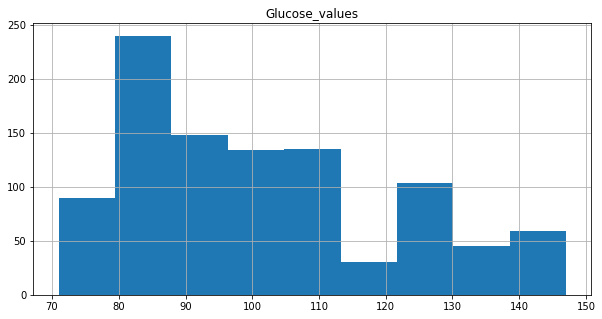

In [97]:
#visualize distribution of numerical attributes by histogram
import matplotlib.pyplot as plt

images.hist(bins=9, figsize=(10,5))
plt.show()

## 3) Stratified shuffle spliting into training and testing data

In [98]:
# Stratified shuffle splitting based on categories
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(images, images['Glucose_categories']):
    train_df = images.loc[train_index]
    test_df = images.loc[test_index]

In [99]:
train_df.shape

(788, 3)

## 4) Preprocess the training data

In [100]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [101]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Glucose_values',
    target_size=(240, 320),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Glucose_values',
    target_size=(240, 320),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Glucose_values',
    target_size=(240, 320),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 631 validated image filenames.
Found 157 validated image filenames.
Found 197 validated image filenames.


## 5) Training

In [102]:
inputs = tf.keras.Input(shape=(240, 320, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
20/20 [==============================] - 22s 1s/step - loss: 10556.1719 - val_loss: 9505.5645
Epoch 2/100
20/20 [==============================] - 20s 1s/step - loss: 8708.1592 - val_loss: 5480.9409
Epoch 3/100
20/20 [==============================] - 20s 996ms/step - loss: 2344.2056 - val_loss: 1157.5708
Epoch 4/100
20/20 [==============================] - 22s 1s/step - loss: 636.8917 - val_loss: 481.9298
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 425.0880 - val_loss: 483.8144
Epoch 6/100
20/20 [==============================] - 22s 1s/step - loss: 412.7010 - val_loss: 493.3076
Epoch 7/100
20/20 [==============================] - 21s 1s/step - loss: 410.2497 - val_loss: 468.5491
Epoch 8/100
20/20 [==============================] - 21s 1s/step - loss: 410.0044 - val_loss: 473.9440
Epoch 9/100
20/20 [==============================] - 20s 1s/step - loss: 410.3756 - val_loss: 492.0699
Epoch 10/100
20/20 [==============================] - 20s 1s/st

## 6) Testing

In [103]:
predicted_glucose_values = np.squeeze(model.predict(test_images))
true_glucose_values = test_images.labels
print(predicted_glucose_values)

7/7 [==============================] - 4s 486ms/step
[ 99.78588   97.39409   97.93022   98.46853  100.21061   97.76885
  97.48328   97.54413   96.47728   98.140236  92.23916   96.82459
  98.99328   99.3292    99.01741   97.378     97.41903   92.89184
  97.96673   98.35871   98.766884  98.75588   99.06569  100.730225
  97.600044  97.21061   86.5917    96.11931   99.281105 100.026726
  97.781425  97.01666   98.137    100.37885  100.86143   99.09005
  99.56489   98.20304   98.42263   98.64871   98.15834  102.113686
  98.45606   97.90602   97.99627  101.355156  90.158134  97.92298
  99.413826  99.9781    98.56798   96.982956  96.72946   97.50434
  81.77297   98.68679   97.297485  98.11143   99.61208   97.47517
  97.53981   98.14052   96.35456   98.63071   99.87376   97.34031
  99.21408   97.49366   92.035225  99.543816  99.45141   98.50257
  97.59283   99.86642  102.39045   96.70113  101.37063   99.00894
  98.90425   97.71064   86.85702   96.12207   91.730034  75.627815
  97.71351   94.439

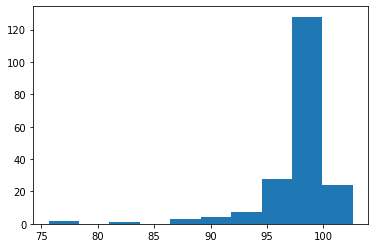

In [104]:
plt.hist(predicted_glucose_values, 10)
plt.show()

In [105]:
rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_glucose_values, predicted_glucose_values)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE: 19.87062
Test R^2 Score: -0.10307
